In [1]:
import math
import sys
import os
import pandas as pd
import numpy as np
# Add the parent directory to the system path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from overfitting import Strategy

In [2]:
# Define Constants
INITIAL_CAPTIAL=100000
SYMBOL = 'BTC'
CSV_PATH = './csv/binance_futures_BTCUSDT_1h 2019-09-09-2024-08-29.csv'
START_TIME='2023-01-01 00:00:00'
END_TIME='2024-08-29 00:00:00'

In [3]:
def gann_swing_chart(high: np.array, low: np.array):
    is_up = None
    tmp_max = high[0]
    tmp_min = low[0]
    tmp_max_i = 0
    tmp_min_i = 0

    tops = []
    bottoms = []

    for i in range(1, len(high)):
        
        up_day = high[i] > high[i-1] and low[i] > low[i-1]
        down_day = high[i] < high[i-1] and low[i] < low[i-1]

        # Determine the trend
        if is_up == None:
            if up_day:
                is_up=True
            elif down_day:
                is_up=False

        if is_up == True: # the last extreme is a bottom
            if high[i] > tmp_max:
                # New high Update
                tmp_max = high[i]
                tmp_max_i = i
            elif down_day == True:
                # Trend reversed, record it
                # top[0] = confirmation index
                # top[1] = index
                # top[2] = price
                top = [i, tmp_max_i, tmp_max]
                tops.append(top)

                # Setup for next bottom
                is_up = False
                tmp_min = low[i]
                tmp_min_i = i

        else: # the last extreme is a top
            if low[i] < tmp_min:
                # New low update
                tmp_min = low[i]
                tmp_min_i = i
            elif up_day == True:
                # Trend reversed, record it
                # bottom[0] = confirmation index
                # bottom[1] = index
                # bottom[2] = price
                bottom = [i, tmp_min_i, tmp_min]
                bottoms.append(bottom)

                # Setup for next top
                is_up=True
                tmp_max = high[i]
                tmp_max_i = i

    return tops, bottoms


In [4]:
def load_data(csv_path, start_time, end_time):
    # Load the CSV file into DataFrame
    df = pd.read_csv(csv_path)
    df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
    df.set_index('open_time', inplace=True)
    # Drop unnecessary columns
    df = df.drop(['close_time', 'volume'], axis=1)
    
    # Convert the relevant columns to numpy arrays
    high = df['high'].values
    low = df['low'].values

    # Apply the Gann Swing Chart calculation
    tops, bottoms = gann_swing_chart(high, low)

    # Store the tops and bottoms in the dataframe
    df['swing_top'] = np.nan
    df['swing_bottom'] = np.nan

    for top in tops:
        # Allocate tops in the corresponding index
        df.at[df.index[top[1]+ 1], 'swing_top'] = top[2]

    for bottom in bottoms:
        # Allocate tops in the corresponding index
        df.at[df.index[bottom[1] + 1], 'swing_bottom'] = bottom[2]

    # Convert start_time and end_time to datetime
    start_time = pd.to_datetime(start_time)
    end_time = pd.to_datetime(end_time)
    # Filter the dataframe by the start and end time
    df = df.loc[start_time:end_time]

    return df


# Example usage
backtest_data = load_data(CSV_PATH, START_TIME, END_TIME)
print(backtest_data.head())


                              open           high            low  \
open_time                                                          
2023-01-01 00:00:00 16537.50000000 16540.90000000 16504.00000000   
2023-01-01 01:00:00 16527.10000000 16554.30000000 16524.10000000   
2023-01-01 02:00:00 16550.50000000 16557.10000000 16534.80000000   
2023-01-01 03:00:00 16542.50000000 16542.50000000 16515.00000000   
2023-01-01 04:00:00 16529.20000000 16530.40000000 16508.80000000   

                             close      swing_top  swing_bottom  
open_time                                                        
2023-01-01 00:00:00 16527.00000000            NaN           NaN  
2023-01-01 01:00:00 16550.40000000            NaN           NaN  
2023-01-01 02:00:00 16542.40000000            NaN           NaN  
2023-01-01 03:00:00 16529.30000000 16557.10000000           NaN  
2023-01-01 04:00:00 16517.80000000            NaN           NaN  


In [5]:
class MyStrategy(Strategy):
    def init(self):
        # Performance Analysis
        self.ups = 0
        self.downs = 0
        self.ups_edge = 0
        self.downs_edge = 0
        self.total_ups = 0
        self.total_downs = 0

        # Variables for swing trend detection
        self.prev_swing_top = None
        self.current_swing_top = None
        self.prev_swing_bottom = None
        self.current_swing_bottom = None
        self.current_trend = None

        self.is_close_position = False

    def next(self, i):
        price = self.data.open[i]
        prev_low = self.data.low[i-1]
        prev_high = self.data.high[i-1]

        swing_top = self.data.swing_top[i]
        swing_bottom = self.data.swing_bottom[i]
        time = pd.to_datetime(self.data.timestamp[i])
        p = self.get_position(SYMBOL)

        if self.is_close_position == True and p.qty != 0:
            self.market_order(SYMBOL, -p.qty)
            self.is_close_position = False

        # Look for new trends when not in a position
        if self.current_trend is None:
            a = (self.broker.cash / price) * 1000
            size = math.floor(a) / 1000

            if self.current_swing_bottom and self.prev_swing_bottom and self.current_swing_bottom > self.prev_swing_bottom:
                # Check for the uptrend
                if prev_high > self.current_swing_top:
                    # Starts the uptrend, enter position
                    self.market_order(SYMBOL, size)
                    self.current_trend = 'up'

            elif self.current_swing_top and self.prev_swing_top and self.current_swing_top < self.prev_swing_top:
                # Check for the downtrend
                if prev_low < self.current_swing_bottom:
                    # Starts the downtrend, enter position
                    # self.market_order(SYMBOL, -size)
                    self.current_trend = 'down'

                            # Detect new swing top and bottom
        if not pd.isna(swing_top):
            self.prev_swing_top = self.current_swing_top if self.current_swing_top else None
            self.current_swing_top = swing_top
            if self.current_trend == 'up':
                # Close the uptrend position when swing top is confirmed
                self.is_close_position = True

                self.current_trend = None

        if not pd.isna(swing_bottom):
            self.prev_swing_bottom = self.current_swing_bottom if self.current_swing_bottom else None
            self.current_swing_bottom = swing_bottom
            if self.current_trend == 'down':
                # Close the downtrend position in the next loop when swing bottom is confirmed
                self.is_close_position = True
                self.current_trend = None


In [6]:
strategy = MyStrategy(backtest_data)
returns = strategy.run()

In [7]:
strategy.fetch_trades()

,id,created_at,symbol,qty,price,type,_status,stop_price,trailing_delta,is_triggered,reason,commission,pnl,realized_pnl
0,a175f6e7,2023-01-01 17:00:00,BTC,60.40000000,16556.10000000,Enum.market,Enum.FILLED,None,None,False,None,199.99768800,0.00000000,-199.99768800
1,57911c84,2023-01-01 22:00:00,BTC,-60.40000000,16597.60000000,Enum.market,Enum.FILLED,None,None,False,None,200.49900800,2506.60000000,2306.10099200
2,a7acebc8,2023-01-04 02:00:00,BTC,60.02000000,16696.10000000,Enum.market,Enum.FILLED,None,None,False,None,200.41998440,0.00000000,-200.41998440
3,816155c0,2023-01-04 06:00:00,BTC,-60.02000000,16848.30000000,Enum.market,Enum.FILLED,None,None,False,None,202.24699320,9135.04400000,8932.79700680
4,b999e80f,2023-01-08 09:00:00,BTC,59.67500000,16938.80000000,Enum.market,Enum.FILLED,None,None,False,None,202.16457800,0.00000000,-202.16457800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,c1c3c657,2024-08-25 15:00:00,BTC,-23.04200000,64122.30000000,Enum.market,Enum.FILLED,None,None,False,None,295.50120732,1712.02060000,1416.51939268
896,00337432,2024-08-25 22:00:00,BTC,22.94800000,64359.00000000,Enum.market,Enum.FILLED,None,None,False,None,295.38206640,0.00000000,-295.38206640
897,5119a296,2024-08-25 23:00:00,BTC,-22.94800000,64444.80000000,Enum.market,Enum.FILLED,None,None,False,None,295.77585408,1968.93840000,1673.16254592
898,0c9e1a08,2024-08-27 19:00:00,BTC,23.82000000,62061.70000000,Enum.market,Enum.FILLED,None,None,False,None,295.66193880,0.00000000,-295.66193880


Number of Years : 1.7
Asset: USDT
Start Date: 2023-01-01 00:00:00
End Date: 2024-08-29 00:00:00
Initial Balnace: 1000000
Final Balance: 1478001.6408766224
CAGR 0.25837121186127265
Culmulative Return: 1.4780016408766188
Sharpe Ratio: 2.269050192512899
Sortino: 4.405394905028814
Max Drawdown: -0.05191833347296704 
Daily Value At Risk: -0.010440082504476674
Skew: 1.070551955424701
Kurtosis: 5.324281905878041
  Net drawdown in %  Peak date Valley date Recovery date Duration
0        5.19183335 2023-03-16  2023-04-08    2023-05-05       37
1        4.40063604 2023-08-09  2023-10-19    2023-11-08       66
2        2.68280000 2024-01-09  2024-01-21    2024-02-09       24
3        2.49867084 2023-05-05  2023-06-14    2023-06-23       36
4        2.44384003 2024-03-14  2024-03-24    2024-03-28       11
5        2.23240717 2024-07-28  2024-08-11    2024-08-23       20
6        2.17713128 2023-01-14  2023-01-27    2023-03-13       41
7        1.88637999 2024-05-20  2024-06-14    2024-07-09       

/Users/kimdohyun/Desktop/github/Overfitting/overfitting/plot/plot.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cumulative_return = cumulative_returns[-1]
/Users/kimdohyun/Desktop/github/Overfitting/overfitting/plot/plot.py:38: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns_series = (1+ returns_series).resample('M').prod() -1
/Users/kimdohyun/Desktop/github/Overfitting/overfitting/plot/plot.py:61: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Culmulative Return: {cumulative_returns[-1]}')


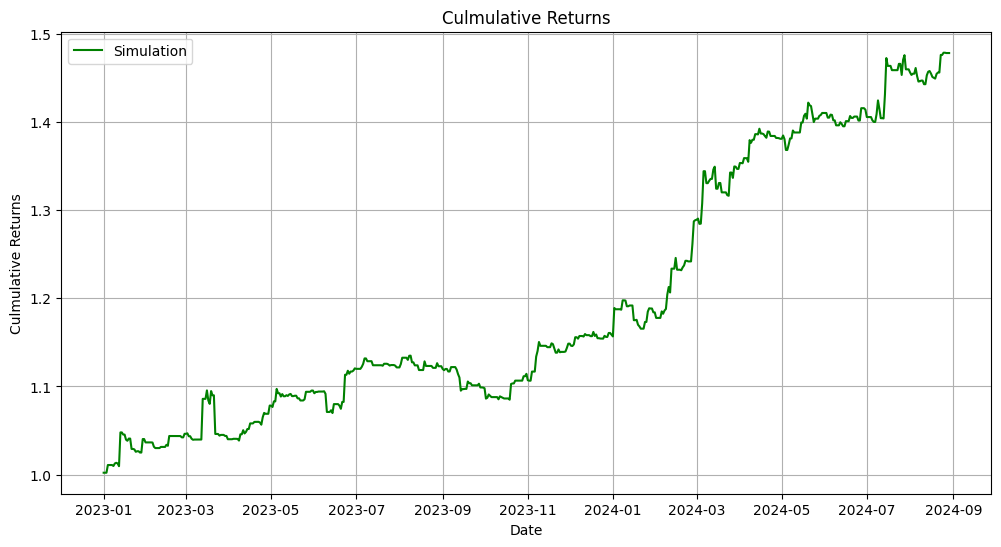

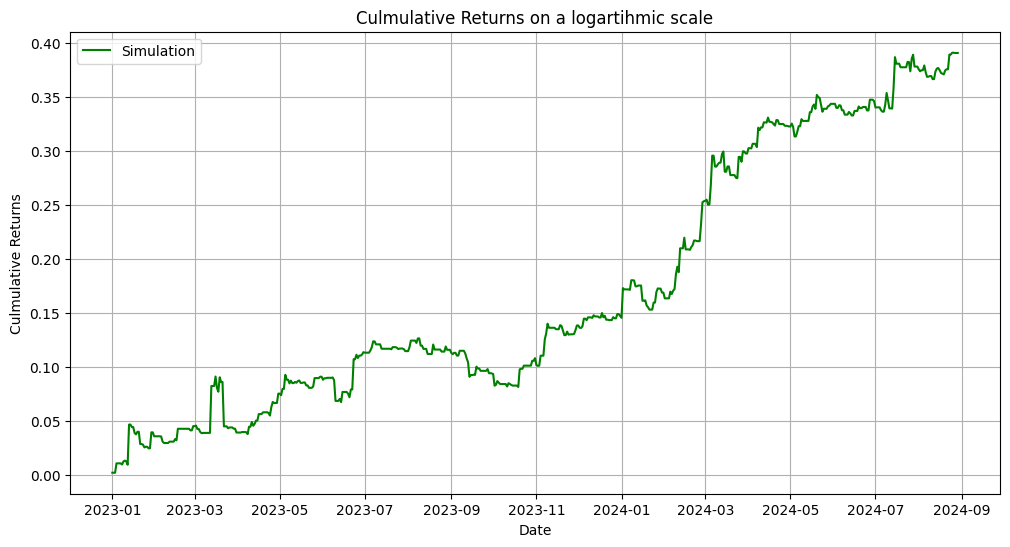

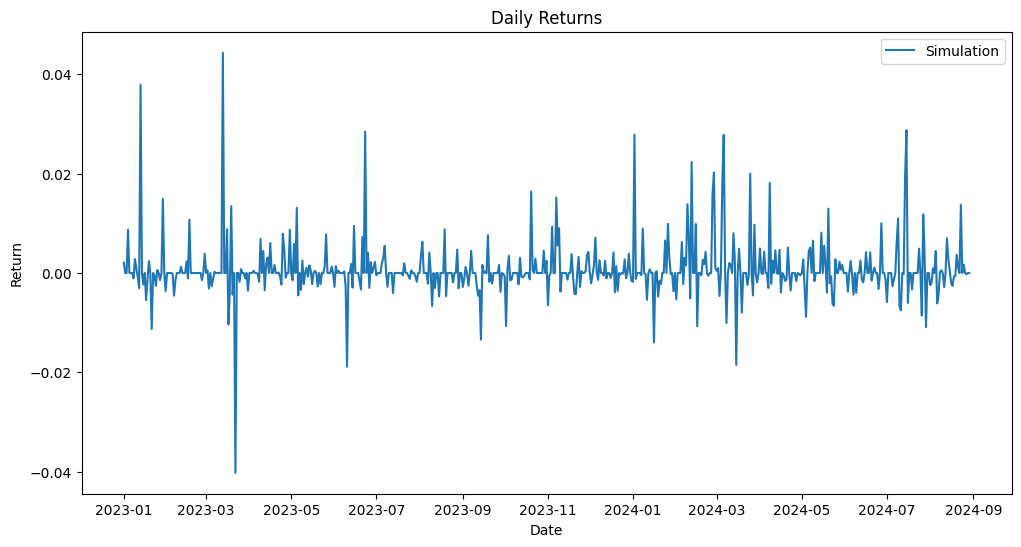

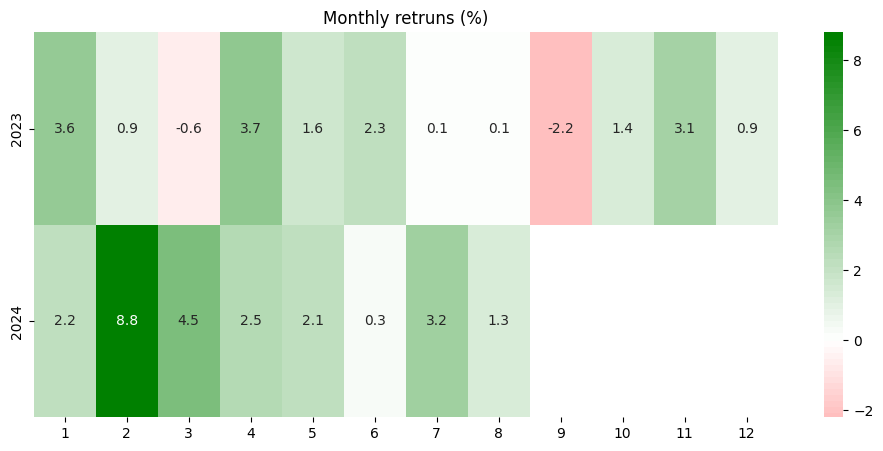

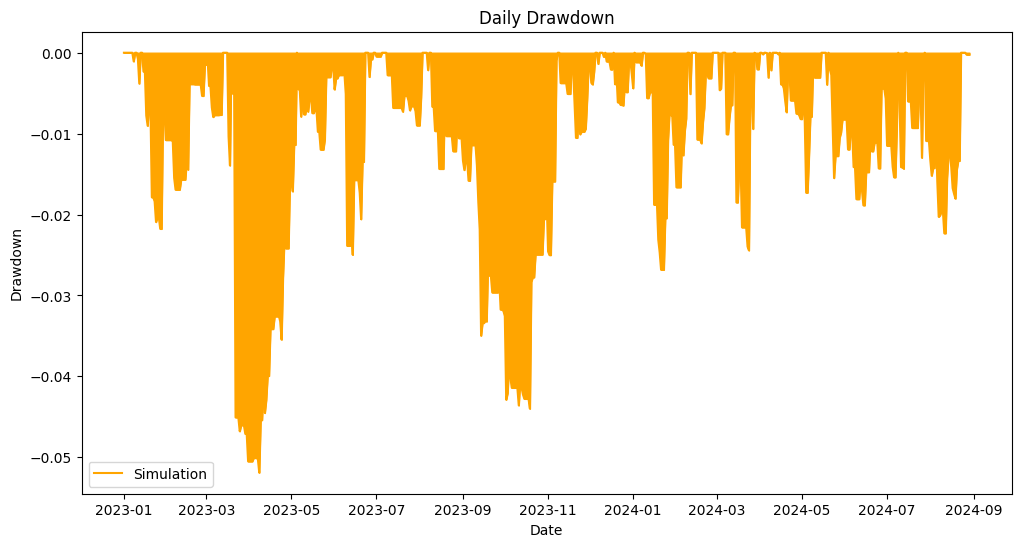

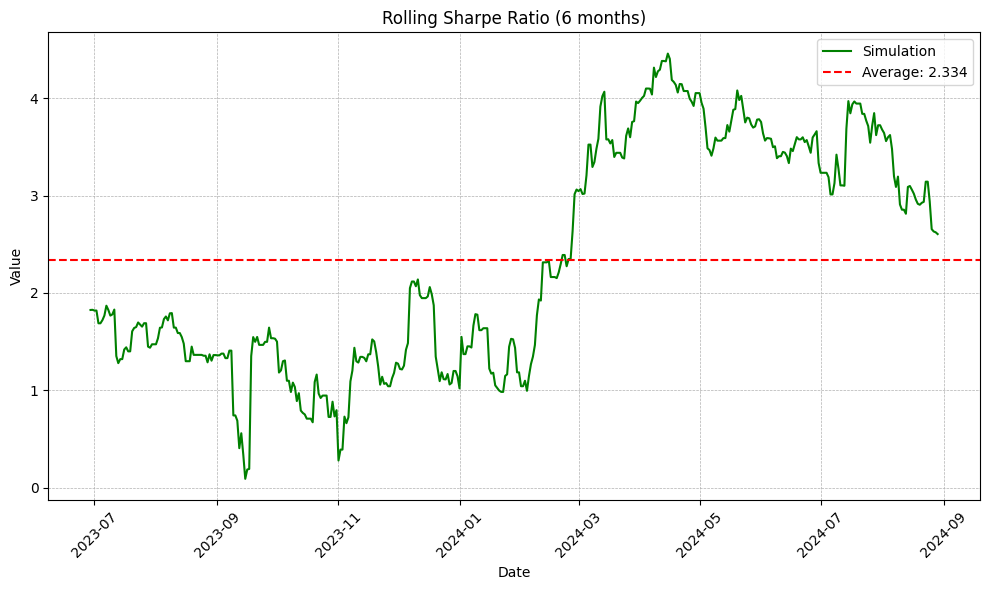

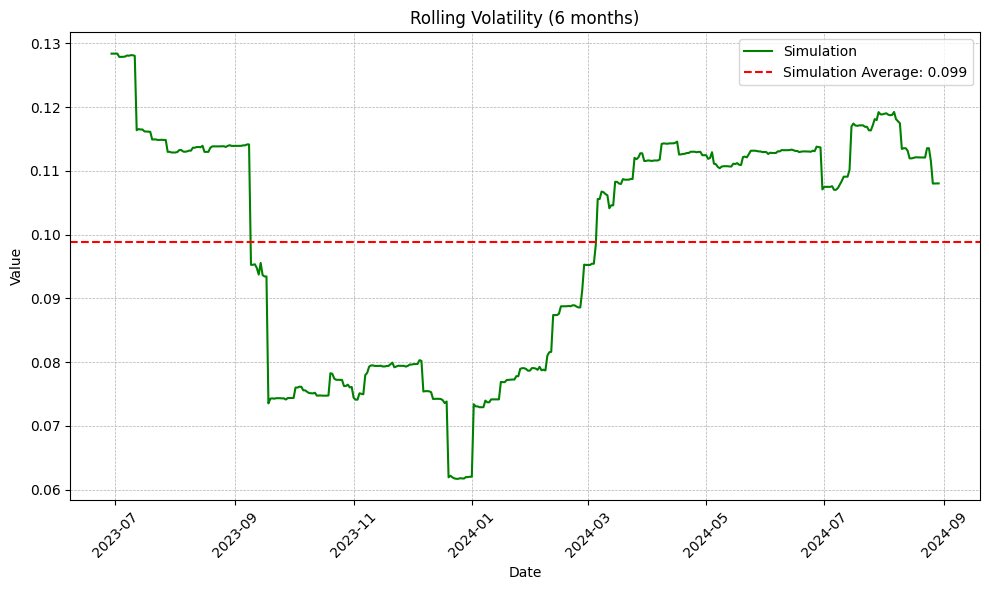

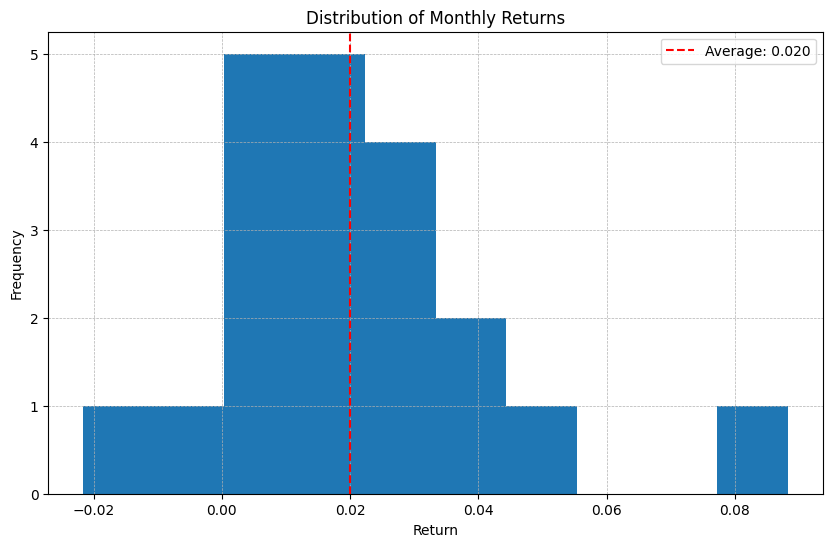

In [8]:
strategy.plot(returns, START_TIME, END_TIME)